**LIBRARY**

In [ ]:
!pip install tensorflow keras numpy matplotlib pandas scikit-learn

**ADD** GPU Usage

In [ ]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

CONFIG FOR GPU GROWTH

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

ADD DATASET ONTO GOOGLE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/dataset/

/content/drive/MyDrive/dataset


**Importing Libraries and Setting Paths**

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

real_images_path = "/content/drive/MyDrive/DFDS/real/"
fake_images_path = "/content/drive/MyDrive/DFDS/fake/"
target_size = (224, 224) # For Resizing images

**Image Preprocessing Function**

In [ ]:
def Image_Preprocessing(image_paths, batch_size): # load each image using PIL
    num_images = len(image_paths)
    while True:
        for i in range(0, num_images, batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = []
            for path in batch_paths:
                image = Image.open(path)
                image = image.resize(target_size) # resize to target size
                image = np.asarray(image) / 255.0 # normalize pixel values
                batch_images.append(image)
            yield np.array(batch_images)

**Generating Paths for Real and Fake Images**

In [ ]:
real_image_paths = [os.path.join(real_images_path, filename) for filename in os.listdir(real_images_path)]
fake_image_paths = [os.path.join(fake_images_path, filename) for filename in os.listdir(fake_images_path)]

In [ ]:
num_real_images = len(real_image_paths)
num_fake_images = len(fake_image_paths)

print("Number of real images loaded:", num_real_images)
print("Number of fake images loaded:", num_fake_images)

Number of real images loaded: 8794
Number of fake images loaded: 8931


**Generators for Real and Fake Images**

In [ ]:
batch_size = 32
real_generator = Image_Preprocessing(real_image_paths, batch_size)
fake_generator = Image_Preprocessing(fake_image_paths, batch_size)

**Combining dataset images and labelling them into Real and Fake Images**

In [ ]:
def combined_generator(real_generator, fake_generator):
    while True:
        real_images = next(real_generator)
        fake_images = next(fake_generator)
        combined_images = np.concatenate((real_images, fake_images))
        real_labels = np.zeros(len(real_images)) # Real images are labeled as 0
        fake_labels = np.ones(len(fake_images)) # fake images are labeled as 1
        combined_labels = np.concatenate((real_labels, fake_labels))
        yield combined_images, combined_labels

Displaying random images with labels:


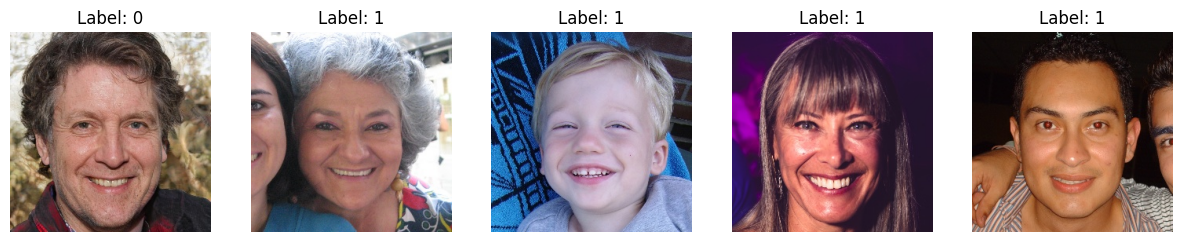

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

num_images_to_display = 5

def display_random_images_with_labels(image_paths, labels, num_images):
    random_indices = random.sample(range(len(image_paths)), num_images)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image_path = image_paths[idx]
        label = labels[idx]
        plt.subplot(1, num_images, i + 1)
        image = mpimg.imread(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Label: {label}")
    plt.show()

real_labels = [1] * len(real_image_paths)
fake_labels = [0] * len(fake_image_paths)

all_image_paths = real_image_paths + fake_image_paths
all_labels = real_labels + fake_labels

print("Displaying random images with labels:")
display_random_images_with_labels(all_image_paths, all_labels, num_images_to_display)


**Splitting Data into Training, Validation, and Test Sets**

In [ ]:
# Splitting data into training, validation, and test sets
train_size = 0.7
val_size = 0.15

combined_train_val_generator = combined_generator(real_generator, fake_generator)

# Collect data from the generator for splitting
combined_data = [next(combined_train_val_generator) for _ in range(len(real_image_paths) // batch_size + 1)]

train_val_data, test_data = train_test_split(combined_data, test_size=1-train_size)
train_data, val_data = train_test_split(train_val_data, test_size=val_size/(1-train_size))

# Unpack the data
train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)
test_images, test_labels = zip(*test_data)

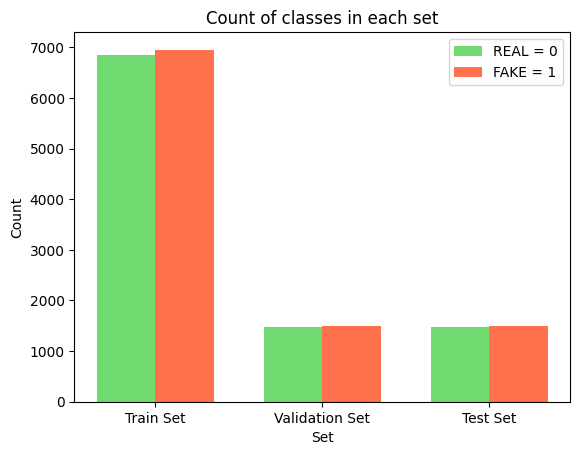

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_counts = np.unique(train_labels, return_counts=True)[1]
val_counts = np.unique(val_labels, return_counts=True)[1]
test_counts = np.unique(test_labels, return_counts=True)[1]

# Plotting
labels = ['Train Set', 'Validation Set', 'Test Set']
real_counts = [train_counts[0], val_counts[0], test_counts[0]]
fake_counts = [train_counts[1], val_counts[1], test_counts[1]]

fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.7

rects1 = ax.bar(np.arange(len(labels)), real_counts, bar_width, label='REAL = 0', color='#33cc33', alpha=opacity)
rects2 = ax.bar(np.arange(len(labels)) + bar_width, fake_counts, bar_width, label='FAKE = 1', color='#ff3300', alpha=opacity)

ax.set_xlabel('Set')
ax.set_ylabel('Count')
ax.set_title('Count of classes in each set')
ax.set_xticks(np.arange(len(labels)) + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [ ]:
def retrieve_dataset(data_set):
    images_arr = np.array(data_set['images'])
    labels_arr = np.array(data_set['label'])
    return images_arr, labels_arr

**Conversion into Numpy arrays**

In [ ]:
def retrieve_dataset(data):
    images = []
    labels = []
    for batch_images, batch_labels in data:
        images.extend(batch_images)
        labels.extend(batch_labels)
    return np.array(images), np.array(labels)

# Convert train, validation, and test sets into NumPy arrays
X_train, y_train = retrieve_dataset(train_data)
X_val, y_val = retrieve_dataset(val_data)
X_test, y_test = retrieve_dataset(test_data)


In [ ]:
import tensorflow as tf
from tensorflow import keras

**DATA AGUMENTATION**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create data generators
train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=32)
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=32)
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=32, shuffle=False)

In [ ]:
from functools import partial
from tensorflow.keras import layers, models

model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(8, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(8, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Fourth Convolutional Block
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((4, 4)),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 8)       1608      
                                                                 
 batch_normalization_1 (Bat  (None, 107, 107, 8)       32        
 chNormalization)                                                
                                                        

**CALL BACK FUNCTION**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
learning_rate_scheduler = LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch))

In [ ]:
history = model.fit(train_generator, epochs=50, batch_size=32, validation_data=val_generator, callbacks=[early_stopping, model_checkpoint, learning_rate_scheduler])

Epoch 1/50
192/192 [==============================] - 11s 40ms/step - loss: 0.7194 - accuracy: 0.5133 - val_loss: 0.7643 - val_accuracy: 0.5181 - lr: 0.0010
Epoch 2/50
192/192 [==============================] - 7s 37ms/step - loss: 0.6866 - accuracy: 0.5465 - val_loss: 0.6761 - val_accuracy: 0.5632 - lr: 9.0000e-04
Epoch 3/50
192/192 [==============================] - 7s 37ms/step - loss: 0.6754 - accuracy: 0.5690 - val_loss: 0.6583 - val_accuracy: 0.6725 - lr: 8.1000e-04
Epoch 4/50
192/192 [==============================] - 7s 38ms/step - loss: 0.6640 - accuracy: 0.5874 - val_loss: 0.6384 - val_accuracy: 0.6899 - lr: 7.2900e-04
Epoch 5/50
192/192 [==============================] - 7s 38ms/step - loss: 0.6558 - accuracy: 0.5952 - val_loss: 0.6678 - val_accuracy: 0.6115 - lr: 6.5610e-04
Epoch 6/50
192/192 [==============================] - 7s 39ms/step - loss: 0.6410 - accuracy: 0.6139 - val_loss: 0.6301 - val_accuracy: 0.7100 - lr: 5.9049e-04
Epoch 7/50
192/192 [=======================

In [ ]:
# Evaluate the model on the test data
evaluation = model.evaluate(test_generator)

# Extract loss and accuracy from the evaluation
loss = evaluation[0]
accuracy = evaluation[1]

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

166/166 [==============================] - 3s 20ms/step - loss: 0.3401 - accuracy: 0.8483
Test Loss: 0.340163349533081
Test Accuracy: 0.8483675103187561


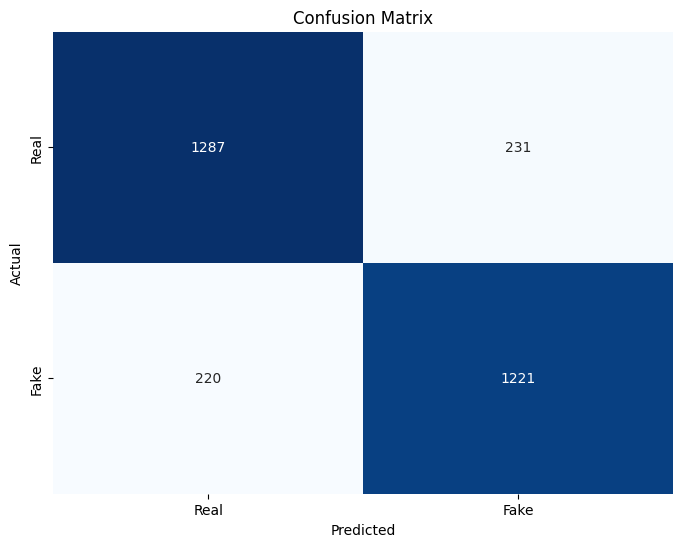

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_binary = model.predict_classes(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Real', 'Fake'],
            yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import random

In [ ]:
random_index = random.randint(0, len(X_test) - 1)
random_image = X_test[random_index]
random_label = y_test[random_index]

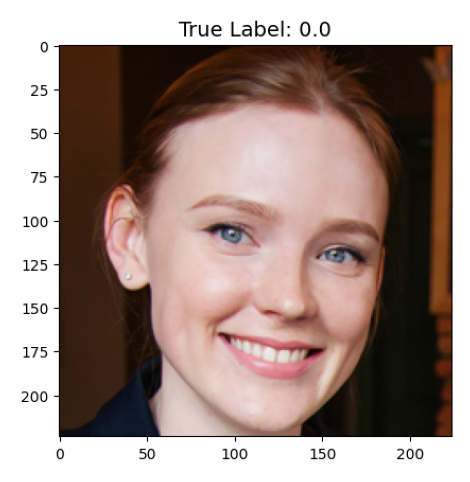

In [ ]:
plt.imshow(random_image)
plt.title(f"True Label: {random_label}")
plt.show()

In [ ]:
random_image = np.reshape(random_image, (1, 224, 224, 3))

In [ ]:
prediction = model.predict(random_image)

1/1 [==============================] - 0s 20ms/step


In [ ]:
predicted_label = 1 if prediction > 0.5 else 0

In [ ]:
print(f"Model Prediction: {predicted_label}")

Model Prediction: 0
